In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import pandas as pd
from tqdm import tqdm

# Thiết bị GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("✅ CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("🚀 GPU name:", torch.cuda.get_device_name(0))

# === Đọc và tiền xử lý dữ liệu ===
df = pd.read_csv("dataset.csv")

# Làm sạch
df['domain'] = df['domain'].astype(str).str.lower().str.strip()
df['label'] = df['label'].str.lower().str.strip()
df['label'] = df['label'].map({'benign': 0, 'dga': 1})

# Bỏ dòng không hợp lệ
# df = df.dropna(subset=['domain', 'label'])

# Token hóa ký tự
domains = df['domain'].tolist()
labels = df['label'].tolist()
all_chars = set(''.join(domains))
char2idx = {c: i + 1 for i, c in enumerate(sorted(all_chars))}  # 0 là padding
max_len = 30

def encode(domain):
    return [char2idx.get(c, 0) for c in domain[:max_len]] + [0] * (max_len - len(domain))

X = [encode(d) for d in domains]
y = labels

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# === Dataset class ===
class DomainDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.long)
        self.y = torch.tensor(y, dtype=torch.float32)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = DomainDataset(X_train, y_train)
test_dataset = DomainDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

# === Mô hình LSTM + Attention + Sigmoid ===
class Attention(nn.Module):
    def __init__(self, hidden_size):
        super(Attention, self).__init__()
        self.attn = nn.Linear(hidden_size, 1)

    def forward(self, lstm_output):
        weights = torch.softmax(self.attn(lstm_output), dim=1)  # [batch, seq_len, 1]
        context = torch.sum(weights * lstm_output, dim=1)       # [batch, hidden_size]
        return context

class DomainBinaryClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim=64, hidden_size=64):
        super(DomainBinaryClassifier, self).__init__()

        # 1. Embedding layer: Chuyển domain từ chỉ số → vector (giống từ điển)
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)

        # 2. LSTM encoder: đóng vai trò là Seq2Seq Encoder
        # Nó "hiểu" chuỗi domain theo thời gian, tạo ra các trạng thái ẩn (hidden states)
        self.encoder = nn.LSTM(
            input_size=embedding_dim,
            hidden_size=hidden_size,
            batch_first=True
        )

        # 3️. Attention mechanism: tìm phần quan trọng trong chuỗi
        # Lấy các hidden states từ LSTM, tạo ra vector ngữ cảnh (context vector)
        self.attention = Attention(hidden_size)

        # 4. Fully Connected + Sigmoid:
        # Nhận context vector, dự đoán xác suất domain là DGA (1) hay benign (0)
        self.fc = nn.Linear(hidden_size, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Bước 1: Nhúng domain → vector
        x = self.embedding(x)  # Shape: [batch_size, seq_len, embedding_dim]

        # Bước 2: Cho vào LSTM (encoder)
        lstm_out, _ = self.encoder(x)  # Output: [batch_size, seq_len, hidden_size]

        # Bước 3: Attention lấy context vector quan trọng từ toàn bộ chuỗi
        context = self.attention(lstm_out)  # Output: [batch_size, hidden_size]

        # Bước 4: Phân loại bằng fully connected + sigmoid
        output = self.fc(context)           # Output: [batch_size, 1]
        output = self.sigmoid(output).squeeze(1)  # Output: [batch_size]
        return output


# Khởi tạo mô hình
model = DomainBinaryClassifier(vocab_size=len(char2idx)+1).to(device)
criterion = nn.BCELoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)

# === Huấn luyện ===
epochs = 20
for epoch in range(epochs):
    model.train()
    total_loss = 0
    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")
    for batch_x, batch_y in loop:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)

        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        loop.set_postfix(loss=loss.item())

    print(f"✅ Epoch {epoch+1} hoàn tất - Total loss: {total_loss:.4f}")

# === Đánh giá ===
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for batch_x, batch_y in test_loader:
        batch_x = batch_x.to(device)
        outputs = model(batch_x)
        preds = (outputs > 0.5).float().cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(batch_y.numpy())

acc = accuracy_score(all_labels, all_preds)
print(f"\n🎯 Accuracy on test set: {acc:.4f}")


✅ CUDA available: True
🚀 GPU name: NVIDIA GeForce GTX 1650


Epoch 1/20: 100%|██████████| 36031/36031 [03:55<00:00, 152.83it/s, loss=0.00225] 


✅ Epoch 1 hoàn tất - Total loss: 2667.6113


Epoch 2/20: 100%|██████████| 36031/36031 [04:09<00:00, 144.49it/s, loss=0.00225] 


✅ Epoch 2 hoàn tất - Total loss: 1872.2640


Epoch 3/20: 100%|██████████| 36031/36031 [04:08<00:00, 144.72it/s, loss=0.000101]


✅ Epoch 3 hoàn tất - Total loss: 1713.1430


Epoch 4/20: 100%|██████████| 36031/36031 [04:06<00:00, 145.96it/s, loss=0.00286] 


✅ Epoch 4 hoàn tất - Total loss: 1619.9817


Epoch 5/20: 100%|██████████| 36031/36031 [04:01<00:00, 149.27it/s, loss=0.419]   


✅ Epoch 5 hoàn tất - Total loss: 1553.8734


Epoch 6/20: 100%|██████████| 36031/36031 [04:06<00:00, 146.30it/s, loss=0.0185]  


✅ Epoch 6 hoàn tất - Total loss: 1514.4317


Epoch 7/20: 100%|██████████| 36031/36031 [04:02<00:00, 148.54it/s, loss=0.00393] 


✅ Epoch 7 hoàn tất - Total loss: 1485.5679


Epoch 8/20: 100%|██████████| 36031/36031 [04:16<00:00, 140.61it/s, loss=0.000292]


✅ Epoch 8 hoàn tất - Total loss: 1459.6713


Epoch 9/20: 100%|██████████| 36031/36031 [04:02<00:00, 148.58it/s, loss=0.00232] 


✅ Epoch 9 hoàn tất - Total loss: 1444.2795


Epoch 10/20: 100%|██████████| 36031/36031 [04:00<00:00, 150.02it/s, loss=0.00153] 


✅ Epoch 10 hoàn tất - Total loss: 1424.6820


Epoch 11/20: 100%|██████████| 36031/36031 [03:57<00:00, 151.44it/s, loss=0.0233]  


✅ Epoch 11 hoàn tất - Total loss: 1409.4492


Epoch 12/20: 100%|██████████| 36031/36031 [03:58<00:00, 150.78it/s, loss=1.08]    


✅ Epoch 12 hoàn tất - Total loss: 1400.0300


Epoch 13/20: 100%|██████████| 36031/36031 [03:46<00:00, 159.30it/s, loss=0.0521]  


✅ Epoch 13 hoàn tất - Total loss: 1382.7699


Epoch 14/20: 100%|██████████| 36031/36031 [04:14<00:00, 141.84it/s, loss=0.00223] 


✅ Epoch 14 hoàn tất - Total loss: 1379.6864


Epoch 15/20: 100%|██████████| 36031/36031 [04:16<00:00, 140.64it/s, loss=0.00188] 


✅ Epoch 15 hoàn tất - Total loss: 1372.1521


Epoch 16/20: 100%|██████████| 36031/36031 [04:20<00:00, 138.50it/s, loss=0.000228]


✅ Epoch 16 hoàn tất - Total loss: 1362.2186


Epoch 17/20: 100%|██████████| 36031/36031 [04:08<00:00, 145.06it/s, loss=0.000235]


✅ Epoch 17 hoàn tất - Total loss: 1356.5292


Epoch 18/20: 100%|██████████| 36031/36031 [03:42<00:00, 162.23it/s, loss=0.00311] 


✅ Epoch 18 hoàn tất - Total loss: 1351.0208


Epoch 19/20: 100%|██████████| 36031/36031 [03:41<00:00, 162.75it/s, loss=0.00109] 


✅ Epoch 19 hoàn tất - Total loss: 1350.2599


Epoch 20/20: 100%|██████████| 36031/36031 [03:41<00:00, 162.85it/s, loss=0.000181]


✅ Epoch 20 hoàn tất - Total loss: 1343.2410

🎯 Accuracy on test set: 0.9856


In [3]:
# === Lưu mô hình đã huấn luyện ===
model_path = "lstm-adamw.pt"
torch.save(model.state_dict(), model_path)
print(f"💾 Mô hình đã được lưu tại: {model_path}")


💾 Mô hình đã được lưu tại: lstm-adamw.pt


In [6]:
# === Tải lại mô hình đã lưu ===
model = DomainBinaryClassifier(vocab_size=len(char2idx)+1).to(device)
model.load_state_dict(torch.load("lstm-adamw.pt"))
model.eval()  # chuyển về chế độ inference

with torch.no_grad():
    test_domain = "paypel.biz"
    encoded = torch.tensor([encode(test_domain)], dtype=torch.long).to(device)
    output = model(encoded)
    prediction = (output.item() > 0.5)
    print(f"🌐 '{test_domain}' được dự đoán là:", "DGA" if prediction else "Benign")


🌐 'paypel.biz' được dự đoán là: Benign


In [7]:
import shap
import numpy as np

# Wrapper function: lấy tensor domain → trả về xác suất DGA (sigmoid)
def model_predict(x_numpy):
    x_tensor = torch.tensor(x_numpy, dtype=torch.long).to(device)
    with torch.no_grad():
        outputs = model(x_tensor)
    return outputs.cpu().numpy()


c:\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
# Chọn domain để phân tích
sample_domains = ["paypal-login.biz", "google.com", "xjksdqwq.ru"]

# Encode
X_encoded = np.array([encode(domain) for domain in sample_domains])


In [9]:
explainer = shap.KernelExplainer(model_predict, X_encoded)
shap_values = explainer.shap_values(X_encoded)


100%|██████████| 3/3 [00:02<00:00,  1.17it/s]


📘 Giải thích cho domain: paypal-login.biz


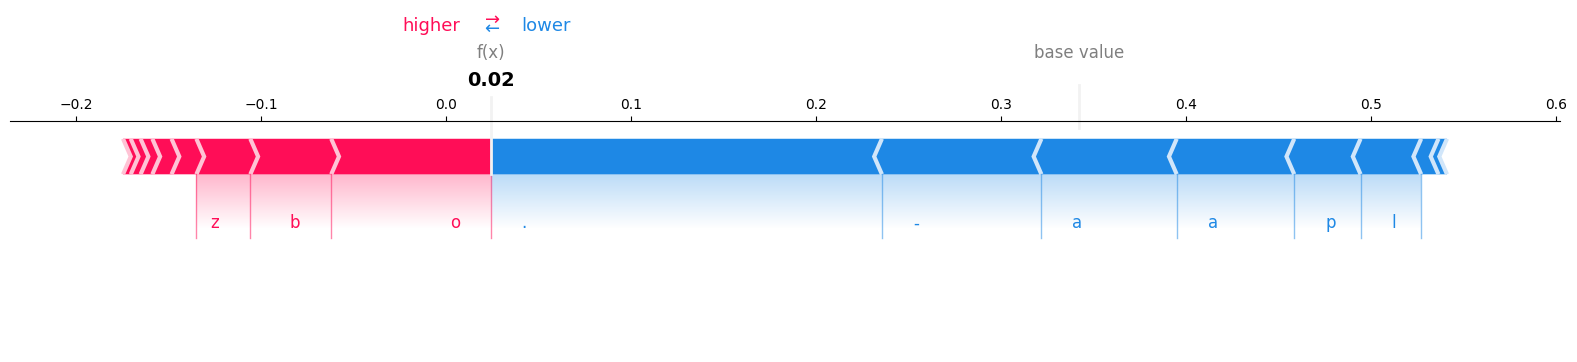

📘 Giải thích cho domain: google.com


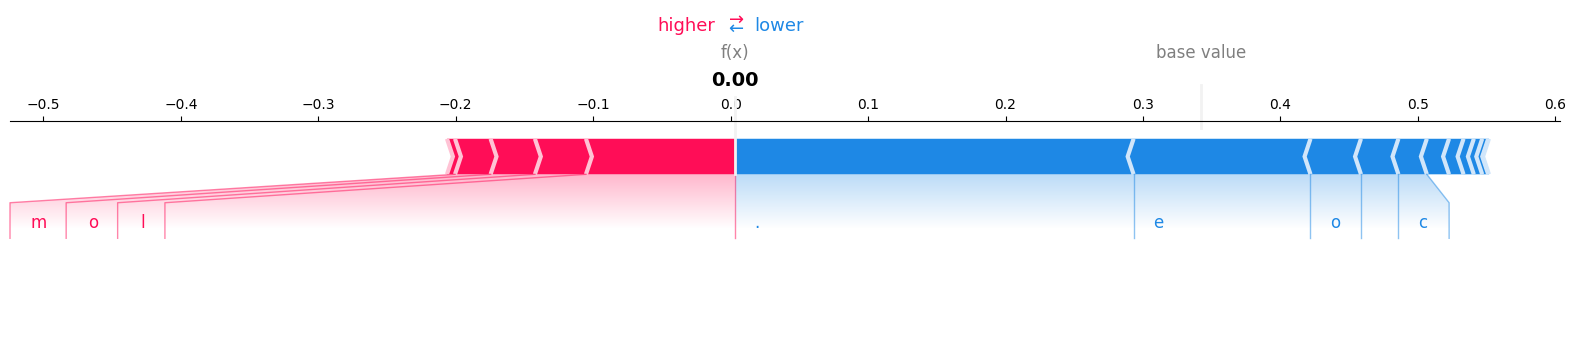

📘 Giải thích cho domain: xjksdqwq.ru


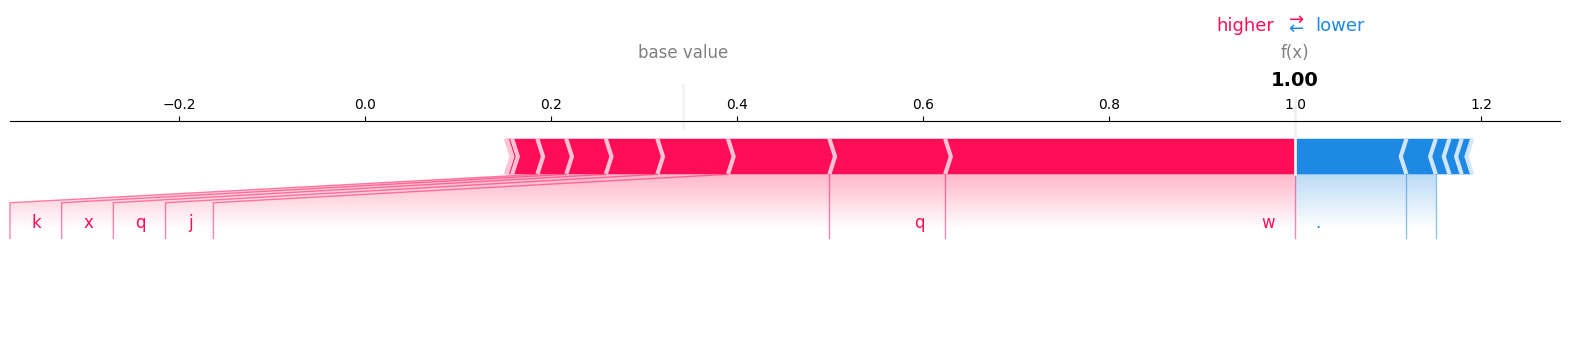

In [10]:
# Lấy ký tự theo chỉ số (ngược lại với char2idx)
idx2char = {v: k for k, v in char2idx.items()}

# Chuyển domain dạng token → dạng ký tự để hiển thị
domain_tokens = [[idx2char.get(idx, "") for idx in row] for row in X_encoded]

# SHAP plot
shap.initjs()
for i, domain in enumerate(sample_domains):
    print(f"📘 Giải thích cho domain: {domain}")
    shap.force_plot(
        base_value=explainer.expected_value,
        shap_values=shap_values[i],
        features=domain_tokens[i],
        matplotlib=True
    )


PermutationExplainer explainer: 101it [00:14,  2.34it/s]                         
C:\Users\PongZua\AppData\Local\Temp\ipykernel_17628\519307612.py:46: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=sorted_chars, y=values, palette="coolwarm")


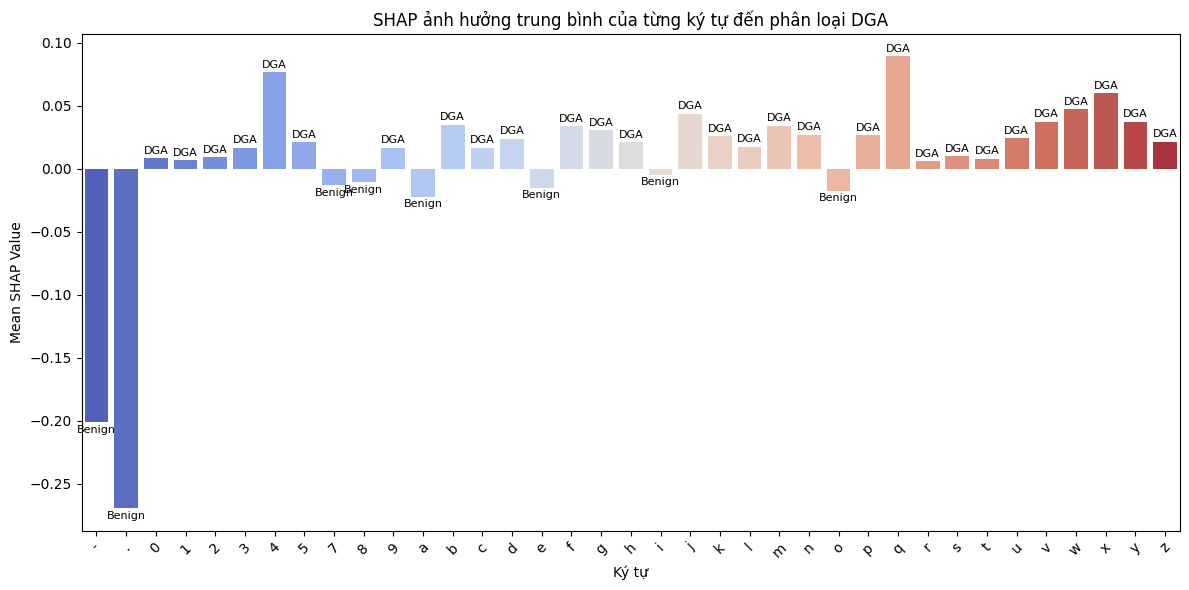

In [16]:
import shap
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import torch
from torch.utils.data import DataLoader

# === Lấy 100 mẫu test đầu tiên ===
sample_loader = DataLoader(test_dataset, batch_size=100, shuffle=False)
sample_x, _ = next(iter(sample_loader))
sample_x = sample_x.to(device)

# === Tạo hàm wrapper cho mô hình ===
def model_wrapper(x_numpy):
    x_tensor = torch.tensor(x_numpy, dtype=torch.long).to(device)
    with torch.no_grad():
        return model(x_tensor).detach().cpu().numpy()

# === Chuyển sample_x sang numpy để SHAP hoạt động ===
sample_x_np = sample_x.detach().cpu().numpy()

# === Tạo Explainer và tính SHAP values ===
explainer = shap.Explainer(model_wrapper, sample_x_np)
shap_values = explainer(sample_x_np)

# === Đếm ảnh hưởng của từng ký tự ===
char_contributions = defaultdict(list)

for i, sample in enumerate(sample_x_np):
    shap_val = shap_values.values[i]  # shape [seq_len]
    for j, idx in enumerate(sample):
        char = [k for k, v in char2idx.items() if v == idx]
        if char:
            char_contributions[char[0]].append(shap_val[j])

# === Trung bình hóa ảnh hưởng từng ký tự ===
mean_contribs = {char: np.mean(vals) for char, vals in char_contributions.items()}

# === Vẽ heatmap ===
plt.figure(figsize=(12, 6))
sorted_chars = sorted(mean_contribs.keys())
values = [mean_contribs[c] for c in sorted_chars]

# Tạo barplot
ax = sns.barplot(x=sorted_chars, y=values, palette="coolwarm")

# Thêm nhãn +DGA / -Benign vào từng cột
for i, val in enumerate(values):
    label = "DGA" if val > 0 else "Benign"
    ax.text(i, val + (0.002 if val > 0 else -0.002), label,
            ha='center', va='bottom' if val > 0 else 'top',
            fontsize=8, color='black')

# Tiêu đề & format
plt.title("SHAP ảnh hưởng trung bình của từng ký tự đến phân loại DGA")
plt.ylabel("Mean SHAP Value")
plt.xlabel("Ký tự")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import pandas as pd
from tqdm import tqdm

# Thiết bị GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("✅ CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("🚀 GPU name:", torch.cuda.get_device_name(0))

# === Đọc và tiền xử lý dữ liệu ===
df = pd.read_csv("dataset.csv")

# Làm sạch
df['domain'] = df['domain'].astype(str).str.lower().str.strip()
df['label'] = df['label'].str.lower().str.strip()
df['label'] = df['label'].map({'benign': 0, 'dga': 1})

# Bỏ dòng không hợp lệ
# df = df.dropna(subset=['domain', 'label'])

# Token hóa ký tự
domains = df['domain'].tolist()
labels = df['label'].tolist()
all_chars = set(''.join(domains))
char2idx = {c: i + 1 for i, c in enumerate(sorted(all_chars))}  # 0 là padding
max_len = 30

def encode(domain):
    return [char2idx.get(c, 0) for c in domain[:max_len]] + [0] * (max_len - len(domain))

X = [encode(d) for d in domains]
y = labels

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# === Dataset class ===
class DomainDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.long)
        self.y = torch.tensor(y, dtype=torch.float32)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = DomainDataset(X_train, y_train)
test_dataset = DomainDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

# === Mô hình LSTM + Attention + Sigmoid ===
class Attention(nn.Module):
    def __init__(self, hidden_size):
        super(Attention, self).__init__()
        self.attn = nn.Linear(hidden_size, 1)

    def forward(self, lstm_output):
        weights = torch.softmax(self.attn(lstm_output), dim=1)  # [batch, seq_len, 1]
        context = torch.sum(weights * lstm_output, dim=1)       # [batch, hidden_size]
        return context

class DomainBinaryClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim=64, hidden_size=64, dropout_rate=0.5):
        super(DomainBinaryClassifier, self).__init__()

        # Embedding
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)

        # BiLSTM (2 chiều)
        self.encoder = nn.LSTM(
            input_size=embedding_dim,
            hidden_size=hidden_size,
            batch_first=True,
            bidirectional=True  # bật BiLSTM
        )

        # Attention nhận hidden_size * 2 do BiLSTM có 2 chiều
        self.attention = Attention(hidden_size * 2)

        # Dropout + ReLU activation
        self.dropout = nn.Dropout(p=dropout_rate)
        self.activation = nn.ReLU()

        # Fully connected + sigmoid
        self.fc = nn.Linear(hidden_size * 2, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.embedding(x)                          # [batch, seq_len, emb_dim]
        lstm_out, _ = self.encoder(x)                  # [batch, seq_len, hidden_size * 2]
        context = self.attention(lstm_out)             # [batch, hidden_size * 2]
        context = self.dropout(context)                # Dropout
        context = self.activation(context)             # ReLU
        output = self.fc(context)                      # [batch, 1]
        output = self.sigmoid(output).squeeze(1)       # [batch]
        return output


# Khởi tạo mô hình
model = DomainBinaryClassifier(vocab_size=len(char2idx)+1).to(device)
criterion = nn.BCELoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)

# === Huấn luyện ===
epochs = 20
for epoch in range(epochs):
    model.train()
    total_loss = 0
    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")
    for batch_x, batch_y in loop:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)

        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        loop.set_postfix(loss=loss.item())

    print(f"✅ Epoch {epoch+1} hoàn tất - Total loss: {total_loss:.4f}")

# === Đánh giá ===
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for batch_x, batch_y in test_loader:
        batch_x = batch_x.to(device)
        outputs = model(batch_x)
        preds = (outputs > 0.5).float().cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(batch_y.numpy())

acc = accuracy_score(all_labels, all_preds)
print(f"\n🎯 Accuracy on test set: {acc:.4f}")


c:\Python312\Lib\site-packages\torch\utils\_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(


✅ CUDA available: True
🚀 GPU name: NVIDIA GeForce GTX 1650


Epoch 1/20: 100%|██████████| 36031/36031 [05:05<00:00, 118.03it/s, loss=0.00918] 


✅ Epoch 1 hoàn tất - Total loss: 2770.5651


Epoch 2/20: 100%|██████████| 36031/36031 [04:53<00:00, 122.94it/s, loss=0.000461]


✅ Epoch 2 hoàn tất - Total loss: 1897.1652


Epoch 3/20: 100%|██████████| 36031/36031 [04:44<00:00, 126.85it/s, loss=1.72]    


✅ Epoch 3 hoàn tất - Total loss: 1721.5775


Epoch 4/20: 100%|██████████| 36031/36031 [05:05<00:00, 118.04it/s, loss=0.000425]


✅ Epoch 4 hoàn tất - Total loss: 1635.2588


Epoch 5/20: 100%|██████████| 36031/36031 [05:20<00:00, 112.40it/s, loss=0.0237]  


✅ Epoch 5 hoàn tất - Total loss: 1567.9282


Epoch 6/20: 100%|██████████| 36031/36031 [04:55<00:00, 121.87it/s, loss=0.0144]  


✅ Epoch 6 hoàn tất - Total loss: 1521.3889


Epoch 7/20: 100%|██████████| 36031/36031 [05:10<00:00, 116.07it/s, loss=0.00147] 


✅ Epoch 7 hoàn tất - Total loss: 1486.1633


Epoch 8/20: 100%|██████████| 36031/36031 [04:56<00:00, 121.47it/s, loss=0.109]   


✅ Epoch 8 hoàn tất - Total loss: 1459.4474


Epoch 9/20: 100%|██████████| 36031/36031 [05:31<00:00, 108.85it/s, loss=0.00115] 


✅ Epoch 9 hoàn tất - Total loss: 1434.4501


Epoch 10/20: 100%|██████████| 36031/36031 [05:23<00:00, 111.52it/s, loss=0.00658] 


✅ Epoch 10 hoàn tất - Total loss: 1416.7938


Epoch 11/20: 100%|██████████| 36031/36031 [04:48<00:00, 124.81it/s, loss=0.00142] 


✅ Epoch 11 hoàn tất - Total loss: 1411.6123


Epoch 12/20: 100%|██████████| 36031/36031 [04:55<00:00, 121.92it/s, loss=0.302]   


✅ Epoch 12 hoàn tất - Total loss: 1397.3688


Epoch 13/20: 100%|██████████| 36031/36031 [05:02<00:00, 119.19it/s, loss=0.00168] 


✅ Epoch 13 hoàn tất - Total loss: 1380.2495


Epoch 14/20: 100%|██████████| 36031/36031 [04:53<00:00, 122.71it/s, loss=0.00262] 


✅ Epoch 14 hoàn tất - Total loss: 1386.3053


Epoch 15/20: 100%|██████████| 36031/36031 [04:53<00:00, 122.69it/s, loss=0.00238] 


✅ Epoch 15 hoàn tất - Total loss: 1371.1811


Epoch 16/20: 100%|██████████| 36031/36031 [05:06<00:00, 117.69it/s, loss=0.000336]


✅ Epoch 16 hoàn tất - Total loss: 1365.1092


Epoch 17/20: 100%|██████████| 36031/36031 [04:49<00:00, 124.64it/s, loss=0.064]   


✅ Epoch 17 hoàn tất - Total loss: 1357.6264


Epoch 18/20: 100%|██████████| 36031/36031 [04:51<00:00, 123.73it/s, loss=0.0387]  


✅ Epoch 18 hoàn tất - Total loss: 1343.8449


Epoch 19/20: 100%|██████████| 36031/36031 [05:10<00:00, 115.95it/s, loss=0.0441]  


✅ Epoch 19 hoàn tất - Total loss: 1341.5979


Epoch 20/20: 100%|██████████| 36031/36031 [05:04<00:00, 118.45it/s, loss=0.000145]


✅ Epoch 20 hoàn tất - Total loss: 1339.8037

🎯 Accuracy on test set: 0.9851
